In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Dataset Labelling

In [4]:
class BrainMRIDataset(Dataset):
  def __init__(self, data_dir, reshape=True, height=128, width=128, autoencoder=False):
    self.data_directory = data_dir
    self.image_links, self.labels = self._load_data(reshape, height, width)
    self.reshape = reshape
    self.height = height
    self.width = width

  def _load_data(self, reshape, height, width):
    no_class = glob(os.path.join(self.data_directory, 'no', '*'))
    yes_class = glob(os.path.join(self.data_directory, 'yes', '*'))
    labels = [0] * len(no_class) + [1] * len(yes_class)
    image_links = no_class + yes_class

    return image_links, labels

  def __len__(self):
    return len(self.image_links)

  def __getitem__(self, idx):
    image_path = self.image_links[idx]
    label = self.labels[idx]

    # If there's only one image path, convert it to a list for consistency
    if type(image_path) == str:
        image_path = [image_path]

    image_tensor_list = [self._get_image_tensor(image) for image in image_path]
    label_tensor = torch.tensor(label, device=device)

    return [torch.stack(image_tensor_list), label_tensor]

  def _get_image_tensor(self, image_path):
    image = Image.open(image_path).convert("L")

    if self.reshape:
        image = image.resize((self.height, self.width))

    array = np.asarray(image)
    array = array.reshape(1, self.height, self.width)

    return torch.tensor(array, device=device)

  def __repr__(self):
    return str(pd.DataFrame({"image": self.image_links, "labels": self.labels}))

In [5]:
brain_dataset = BrainMRIDataset('drive/MyDrive/brain_tumor_dataset')
brain_dataset

                                              image  labels
0    drive/MyDrive/brain_tumor_dataset/no/no 97.jpg       0
1    drive/MyDrive/brain_tumor_dataset/no/no 98.jpg       0
2    drive/MyDrive/brain_tumor_dataset/no/no 5.jpeg       0
3    drive/MyDrive/brain_tumor_dataset/no/49 no.jpg       0
4    drive/MyDrive/brain_tumor_dataset/no/11 no.jpg       0
..                                              ...     ...
248  drive/MyDrive/brain_tumor_dataset/yes/Y187.jpg       1
249   drive/MyDrive/brain_tumor_dataset/yes/Y66.JPG       1
250  drive/MyDrive/brain_tumor_dataset/yes/Y106.jpg       1
251  drive/MyDrive/brain_tumor_dataset/yes/Y195.JPG       1
252   drive/MyDrive/brain_tumor_dataset/yes/Y24.jpg       1

[253 rows x 2 columns]

## Customized CNN Tumor Model

In [6]:
class CustomizedBrainTumorModel(nn.Module):
  def __init__(self):
    super(CustomizedBrainTumorModel, self).__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(512 * 4 * 4, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, 2)

    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    # Introducing ReLU in hidden layers
    x = self.pool(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(self.conv5(x))

    x = x.view(-1, 512 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

## Brain Tumor CNN Model

In [7]:
class BrainTumorModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,256,kernel_size=3),
        nn.MaxPool2d(2,2),
        nn.Conv2d(256,32,kernel_size=2)
    )

    self.linear1 = nn.Linear(62,128)
    self.linear2 = nn.Linear(128,64)
    self.flat = nn.Flatten(1)
    self.linear3 = nn.Linear(126976,2)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    x = self.flat(x)
    x = self.linear3(x)

    return x

In [8]:
model = CustomizedBrainTumorModel().to(device)
model

CustomizedBrainTumorModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
next(model.parameters()).device

device(type='cuda', index=0)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [11]:
torch.manual_seed(42)

epochs = 100
batch_size = 32

# Tracking
epoch_count = []
loss_values = []
acc_values = []

for epoch in range(epochs):
  # model.train()
  total_loss = 0.0
  for n in range(len(brain_dataset)//batch_size):
    data, target = brain_dataset[n*batch_size : (n+1)*batch_size]

    ypred = model.forward(data.float())
    loss = loss_fn(ypred, target)

    total_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Train acc
    _, predicted_train_labels = torch.max(ypred, 1)
    train_accuracy = (predicted_train_labels == target).sum().item() / len(target)

  if (epoch % 10 == 0 or epoch == epochs - 1):
    epoch_count.append(epoch)
    loss_val = total_loss / n
    loss_values.append(loss_val)
    acc_values.append(train_accuracy)
    print("Epochs {} ------- Training Loss {:.4f} | Train Accuracy: {:.2f}%".format(epoch, loss_val, train_accuracy * 100))

Epochs 0 ------- Training Loss 7742.1572 | Train Accuracy: 100.00%
Epochs 10 ------- Training Loss 0.8073 | Train Accuracy: 100.00%
Epochs 20 ------- Training Loss 0.8003 | Train Accuracy: 100.00%
Epochs 30 ------- Training Loss 0.7871 | Train Accuracy: 100.00%
Epochs 40 ------- Training Loss 0.8037 | Train Accuracy: 100.00%
Epochs 50 ------- Training Loss 0.7019 | Train Accuracy: 90.62%
Epochs 60 ------- Training Loss 0.6087 | Train Accuracy: 78.12%
Epochs 70 ------- Training Loss 0.2937 | Train Accuracy: 93.75%
Epochs 80 ------- Training Loss 0.3023 | Train Accuracy: 81.25%
Epochs 90 ------- Training Loss 0.0566 | Train Accuracy: 100.00%
Epochs 99 ------- Training Loss 0.5177 | Train Accuracy: 90.62%


*Note: It may show 100% accuracy in training which may be due to less dataset*

In [12]:
# model.state_dict()

## Plotting Train loss Curve

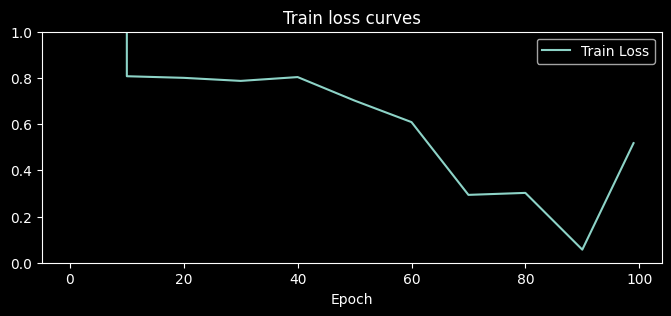

In [13]:
plt.style.use('dark_background')
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.title("Train loss curves")
plt.xlabel("Epoch")

# Set the y-axis limits to the range [0, 1]
plt.ylim(0, 1)

plt.legend();

## PLotting Train Accuracy

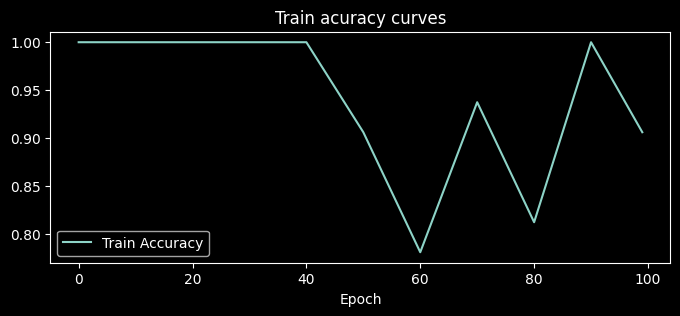

In [14]:
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(acc_values).numpy()), label="Train Accuracy")
plt.title("Train acuracy curves")
plt.xlabel("Epoch")
plt.legend();

## Saving Model

In [15]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents = True, exist_ok =True)

model_name = 'BrainTumorModel.pth'
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj = model.state_dict(),
           f = model_save_path)
print('Saved Successfully')

Saving model to: models/BrainTumorModel.pth
Saved Successfully


## Loading Model

In [16]:
loaded_model = CustomizedBrainTumorModel()
loaded_model.load_state_dict(torch.load(f = model_save_path))

# Transfer loaded model to CUDA
loaded_model.to(device)

print(f"Loading model from",{model_save_path})
print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loading model from {PosixPath('models/BrainTumorModel.pth')}
Loaded model:
CustomizedBrainTumorModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Model on device:
cuda:0


## Predictions using Loaded Model

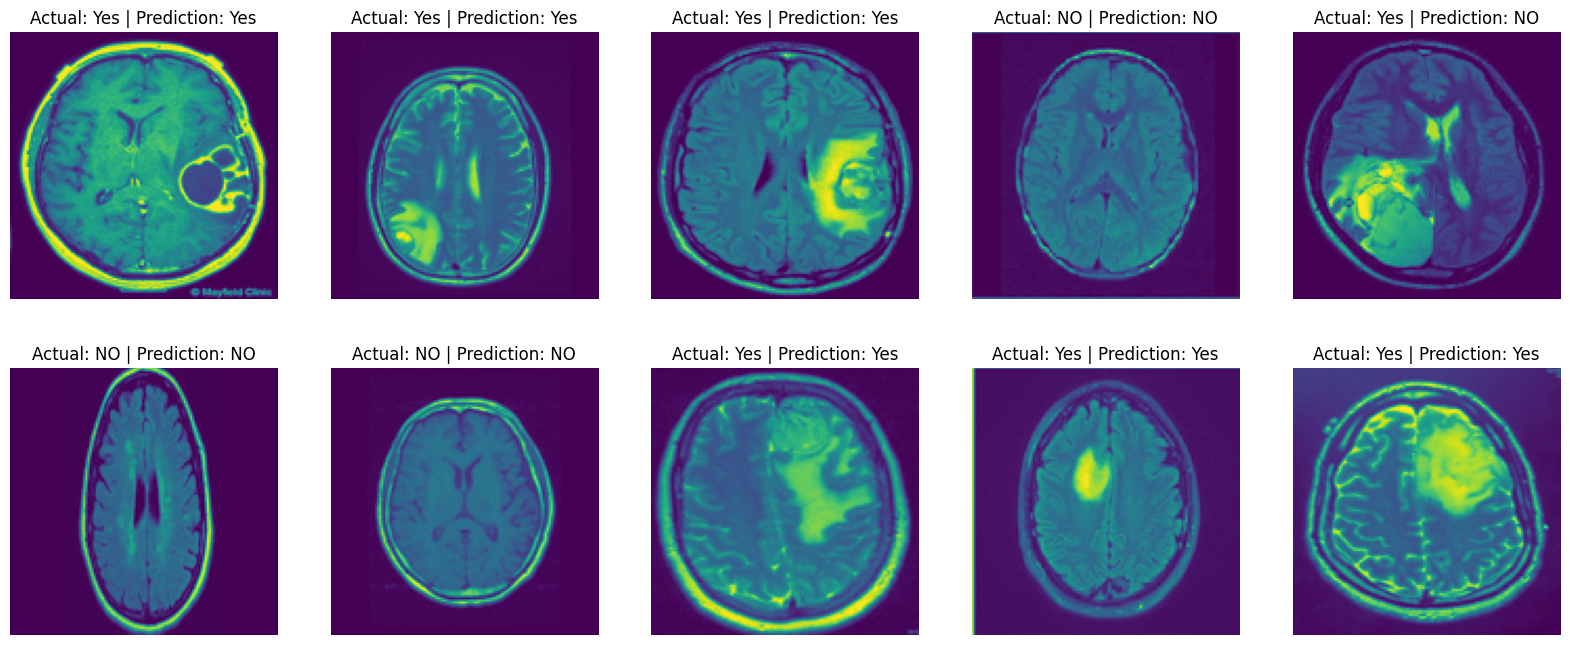

In [23]:
import random

random_indices = random.sample(range(200), 10)
plt.style.use('default')
mapping = {0: "NO", 1: "Yes"}
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

with torch.inference_mode():
    for idx, i in enumerate(random_indices):
        data, target = brain_dataset[i]

        # Make predictions using the loaded model
        pred = loaded_model(data.float())

        pred_class = torch.argmax(pred, dim=1).cpu().detach().item()

        row, col = divmod(idx, 5)
        axes[row, col].imshow(data[0][0].cpu())
        axes[row, col].set_title(f"Actual: {mapping[target.cpu().detach().item()]} | Prediction: {mapping[pred_class]}")
        axes[row, col].axis('off')

plt.show()